In [123]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import copy
import tqdm
from PIL import Image
from albumentations import pytorch as AT
import albumentations as A
import torchvision.datasets as dataset
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import natsort
import time
from ndar_to_board import ndarr_to_board, RealPieces, minimax, moveToIndex
from google.colab.patches import cv2_imshow
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from skorch.callbacks import LRScheduler, Checkpoint 
from skorch.callbacks import Freezer, EarlyStopping

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# for multiprocessing
import multiprocessing as mp


In [3]:
class MobileNet(nn.Module):
    def __init__(self, output_features, num_units=512, drop=0.5,
                 num_units1=256, drop1=0.2):
        super().__init__()
        model =  torchvision.models.mobilenet_v2(pretrained=False)
        n_inputs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
                                nn.Dropout(p=drop1), 
                                nn.Linear(n_inputs, output_features))
        self.model = model
        
    def forward(self, x):
        return self.model(x)


lr_scheduler_mobilenet = LRScheduler(policy='StepLR',
                                  step_size=8,gamma=0.2)
# callback for saving the best on validation accuracy model
checkpoint_mobilenet = Checkpoint(f_params='/content/drive/MyDrive/chess_weights/best_model_mobilenet.pkl',
                            monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
#freezer_vgg = Freezer(lambda x: not x.startswith('model.classifier'))
# callback for early stopping
early_stopping_mobilenet = EarlyStopping(patience=10)
mobilenet = NeuralNetClassifier(
    # pretrained ResNet50 + custom classifier 
    module=MobileNet,          
    # fine tuning model's inner parameters
    module__output_features=13,
    module__num_units=512,
    module__drop=0.5,
    module__num_units1=512,
    module__drop1=0.5,
    # criterion
    criterion=nn.CrossEntropyLoss,
    # batch_size = 128
    batch_size=20,
    # number of epochs to train
    max_epochs=100,
    # optimizer Adam used
    optimizer=torch.optim.Adam,
    optimizer__lr = 0.0025,
    optimizer__weight_decay=1e-6,
    # shuffle dataset while loading
    iterator_train__shuffle=True,
    # load in parallel
    iterator_train__num_workers=4,
    # stratified kfold split of loaded dataset
    train_split=CVSplit(cv=5, stratified=True, random_state=42),
    # callbacks declared earlier
    callbacks=[lr_scheduler_mobilenet, checkpoint_mobilenet, 
                early_stopping_mobilenet],
    # use GPU or CPU
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

mobilenet.initialize()

mobilenet.load_params(f_params='/content/drive/MyDrive/chess_weights/best_model4_mobilenet.pkl')

def test_transform():
    return A.Compose([A.Resize(96, 96), A.Normalize(),
    AT.ToTensor()])


class TestDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        super().__init__()
        self.image_list =image_list
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_list)

    def __getitem__(self, index: int):
        image = self.image_list[index]
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image

def createDataset(path,batch_size):
    test_dataset = TestDataset(path, test_transform())
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4
    )
    return test_loader

classes={0:'Empty',1:'whitePawn',2:'whiteBishop',3:'whiteKnight',4:'whiteRook',5:'whiteQueen',6:'whiteKing',7:'blackPawn',8:'blackBishop',9:'blackKnight',10:'blackRook',11:'blackQueen',12:'blackKing'}


/usr/local/lib/python3.7/dist-packages/skorch/dataset.py:271: FutureWarning: Setting a random_state has no effect since cv is not a float. This will raise an error in a future. You should leave random_state to its default (None), or set cv to a float value.
  FutureWarning


/content/chessboard_detection.py:218: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(contours), hierarchy[0]
/content/chessboard_detection.py:200: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_contours = new_contours[mask]
/content/chessboard_detection.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

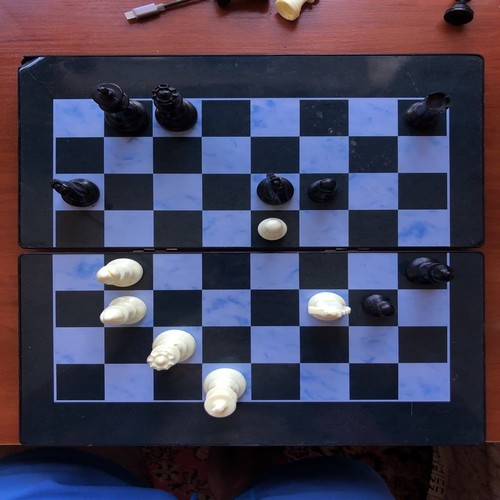

From h1h3
To (7, 2)


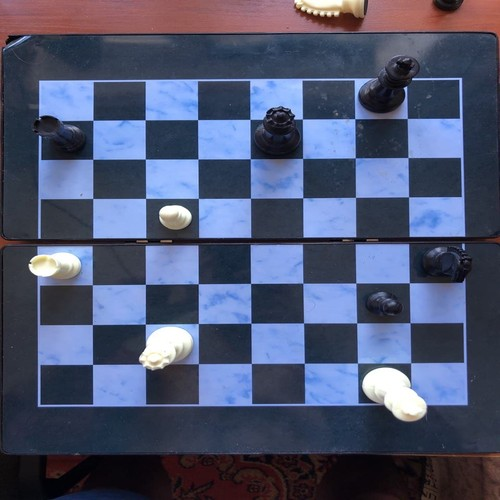

From d7d8
To (3, 7)


In [137]:
class Detector():
    def __init__(self, device, model, testloader,classes):
        self.model = model
        self.loader = testloader
        self.device = device
        self.classes=classes
        self.figures={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
        self.counts ={0:32,1:8,2:2,3:2,4:2,5:1,6:1,7:8,8:2,9:2,10:2,11:1,12:1}
    def predict(self):
        desc=[]
        for batch_idx, X_test in enumerate(self.loader):
          figures_full=[]
          for key in self.figures.keys():
            if self.figures[key]>=self.counts[key]:
              figures_full.append(key)
          prediction= self.model.predict_proba(X_test).flatten()
          for index in figures_full:
            prediction[index] = -1; 
          num_class = np.argmax(prediction)
          if self.figures[num_class]<=self.counts[num_class]:
            desc.append(num_class)
            self.figures[num_class] +=1
        return self.figures,np.array(desc).reshape(8,8)

from PIL import Image
from chessboard_detection import inference, loadImage
import matplotlib.pyplot as plt
import numpy as np
import os 

def cropChessboard(im, tiles, folder='resized', padding = 12, n = 50):
    pictures = []
    for tile in tiles:
        xyxy = [min(tile[0:2]), min(tile[2:4]), max(tile[0:2]), max(tile[2:4])]
        xyxy[0] -= padding
        xyxy[1] -= padding
        xyxy[2] += padding
        xyxy[3] += padding
        xyxy = [max(0, int(c)) for c in xyxy]    # preventing negative and float coordinates 
        cropped = im[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
        cropped = Image.fromarray(cropped)

        cropped = cropped.resize((n, n), resample=Image.BILINEAR)
        
        pictures.append(np.array(cropped))
    return pictures # np.array

path='/content/drive/MyDrive/new_500x500'
img_list = os.listdir(path)
classes={0:'Empty',1:'whitePawn',2:'whiteBishop',3:'whiteKnight',4:'whiteRook',5:'whiteQueen',6:'whiteKing',7:'blackPawn',8:'blackBishop',9:'blackKnight',10:'blackRook',11:'blackQueen',12:'blackKing'}
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
counts_dict ={0:32,1:8,2:2,3:2,4:2,5:1,6:1,7:8,8:2,9:2,10:2,11:1,12:1}
for img_path in img_list:
  imgg = loadImage(os.path.join(path,img_path))
  img= cv2.imread(os.path.join(path,img_path))
  tiles = inference(imgg)
  res = cropChessboard(img, tiles)
  test_loader = createDataset(res, 1)
  detector = Detector(device,mobilenet,test_loader,classes)
  figures,desc = detector.predict()
  unique, counts = np.unique(desc.flatten(), return_counts=True)
  counts_check=dict(zip(unique, counts))
  for key in counts_check.keys():
    if counts_check[key]>counts_dict[key]:
      break
  new_desc = []
  for i in range(len(desc.flatten())):
    new_desc.append(classes[desc.flatten()[i]])
  new_desc= np.array(new_desc).reshape(8,8)
  board = ndarr_to_board(RealPieces,new_desc)
  try:        # changing for conventional datatype    
    minimaxEval, bestMove = minimax(board, 4, -np.inf, np.inf, False) # finding best move
    start, finish = moveToIndex(bestMove)
    move = chess.Move.from_uci(bestMove)
    boardCurrent = board
    board.push(move) # board after best move
    cv2_imshow(img)
    print('From',bestMove)
    print('To',finish)
  except:
    pass
    
